In [2]:
%%capture
#!pip install -U datasets
!pip install transformers nltk numpy datasets==2.16.0

In [3]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    RobertaTokenizer, ViTImageProcessor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using RobertaModel)
    RobertaModel, AutoConfig, ViTModel,           
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging,
    
    EarlyStoppingCallback
)
import warnings 
warnings.filterwarnings('ignore')

import nltk
nltk.download('wordnet')
import nltk
import subprocess
import safetensors
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

2024-06-19 18:04:48.240043: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 18:04:48.240213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 18:04:48.399444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordne

In [4]:
# cache for Hugging Face Transformers and Datasets.
os.environ['HF_HOME'] = os.path.join(".", "cache")

set_caching_enabled(True)
logging.set_verbosity_error()

In [5]:
#check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


cpu


# Loading the dataset

In [6]:
# load dataset from CSV files for training and testing
dataset = load_dataset(
    "csv", 
    data_files={
        "train": "/kaggle/input/processed-daquar-dataset/data_train.csv",
        "test": "/kaggle/input/processed-daquar-dataset/data_eval.csv"
    }
)

# read answer space from file and split into an array by line
with open("/kaggle/input/processed-daquar-dataset/answer_space.txt") as f:
    answer_space = f.read().splitlines()

# label each item in the dataset with their respective answers
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6795 [00:00<?, ? examples/s]

Map:   0%|          | 0/5673 [00:00<?, ? examples/s]

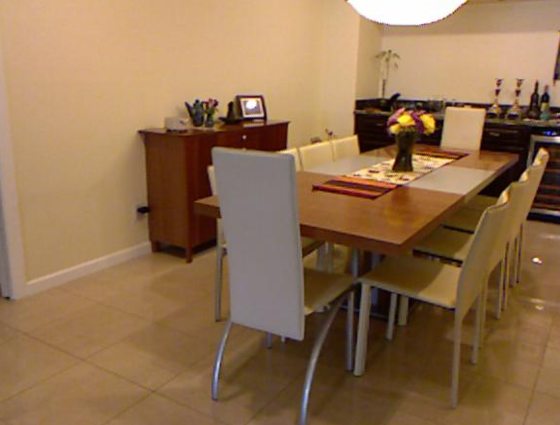

Question:	 what is on the flower vase
Answer:		 chandelier (Label: 107)
/kaggle/input/processed-daquar-dataset/images/image1434.png


'chandelier'

In [29]:
import IPython.display as display

def show_example(train=True, idx=None):
    dataset_type = "train" if train else "test"
    data = dataset[dataset_type]

    if idx is None:
        idx = np.random.randint(len(data))

    image_path =  "/kaggle/input/processed-daquar-dataset/images/"+ f"{data[idx]['image_id']}.png"
    image = Image.open(image_path)
    display.display(image)

    question = data[idx]["question"]
    answer = data[idx]["answer"]
    label = data[idx]["label"]

    print(f"Question:\t {question}")
    print(f"Answer:\t\t {answer} (Label: {label})")
    print(image_path)

    return answer
show_example()

# Building the Model

In [ ]:
@dataclass
class MultimodalCollator:
    tokenizer: RobertaTokenizer
    preprocessor: ViTImageProcessor
    
    def tokenize_text(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        """
        Tokenize text inputs and return relevant tokenized information.
        """
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }
    
    def preprocess_images(self, images: List[str]) -> Dict[str, torch.Tensor]:
        """
        Extract features from images and return the processed pixel values.
        """
        processed_images = self.preprocessor(
            images=[
                Image.open(os.path.join("/kaggle/input/processed-daquar-dataset/images/", f"{image_id}.png")).convert('RGB')
                for image_id in images
            ],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict) -> Dict[str, torch.Tensor]:
        """
        Process raw batch data, tokenize text and extract image features, returning a dictionary
        containing processed inputs and labels.
        """
        question_batch = raw_batch_dict['question'] if isinstance(raw_batch_dict, dict) else [i['question'] for i in raw_batch_dict]
        image_id_batch = raw_batch_dict['image_id'] if isinstance(raw_batch_dict, dict) else [i['image_id'] for i in raw_batch_dict]
        label_batch = raw_batch_dict['label'] if isinstance(raw_batch_dict, dict) else [i['label'] for i in raw_batch_dict]

        return {
            **self.tokenize_text(question_batch),
            **self.preprocess_images(image_id_batch),
            'labels': torch.tensor(label_batch, dtype=torch.int64),
        }


In [ ]:
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,
        num_labels: int = len(answer_space),
        intermediate_dim: int = 512,
        pretrained_text_name: str = 'roberta-base',
        pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'
    ):
        """
        Initializes the Multimodal VQA Model.

        Args:
            num_labels (int): Number of labels in the answer space.
            intermediate_dim (int): Dimensionality of the intermediate layer in the fusion module.
            pretrained_text_name (str): Pretrained name for the text encoder.
            pretrained_image_name (str): Pretrained name for the image encoder.
        """
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        # Text and image encoders
        
        self.text_encoder = RobertaModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = ViTModel.from_pretrained(self.pretrained_image_name)
        
        # Fusion module
        self.fusion = nn.Sequential(
            nn.LayerNorm(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size),
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(intermediate_dim, self.num_labels)
        )
#         self.fusion.apply(self.init_weights)
        
        # Classifier
#         self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)
            
    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):
        """
        Forward pass of the model.

        Args:
            input_ids (torch.LongTensor): Tokenized input IDs for text.
            pixel_values (torch.FloatTensor): Pixel values for images.
            attention_mask (Optional[torch.LongTensor]): Attention mask for text.
            token_type_ids (Optional[torch.LongTensor]): Token type IDs for text.
            labels (Optional[torch.LongTensor]): Ground truth labels.

        Returns:
            Dict: Dictionary containing model outputs, including logits. If labels are provided, also includes loss.
        """
        # Encode text with masking
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
#         print(encoded_text)
        
        # Encode images
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
#         print(encoded_image)
        
        # Combine encoded texts and images
#         fused_output = self.fusion(
#             torch.cat(
#                 [
#                     encoded_text['pooler_output'],
#                     encoded_image['pooler_output'],
#                 ],
#                 dim=1
#             )
#         )
        
        # Make predictions
        logits = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        
        out = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out


In [ ]:
def create_multimodal_vqa_collator_and_model(text_encoder='roberta-base', image_encoder='google/vit-base-patch16-224-in21k'):
    """
    Creates a Multimodal VQA collator and model.

    Args:
        text_encoder (str): Pretrained name for the text encoder.
        image_encoder (str): Pretrained name for the image encoder.

    Returns:
        Tuple: Multimodal collator and VQA model.
    """
    # Initialize tokenizer and feature extractor
    tokenizer = RobertaTokenizer.from_pretrained(text_encoder)
    preprocessor = ViTImageProcessor.from_pretrained(image_encoder)
    
    # Create Multimodal Collator
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Create Multimodal VQA Model
    multimodal_model = MultimodalVQAModel(
        pretrained_text_name=text_encoder,
        pretrained_image_name=image_encoder
    ).to(device)

    return multimodal_collator, multimodal_model


In [ ]:
def wup_measure(a, b, similarity_threshold=0.925):
    """
    Computes the Wu-Palmer similarity score between two words or phrases.

    Args:
        a (str): First word or phrase.
        b (str): Second word or phrase.
        similarity_threshold (float): Threshold for similarity to consider semantic fields.

    Returns:
        float: Wu-Palmer similarity score.
    """
    def get_semantic_field(word):
        """
        Retrieves the semantic field for a word.

        Args:
            word (str): Word to retrieve the semantic field for.

        Returns:
            Tuple: Tuple containing the semantic field and weight.
        """
        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight

    def get_stem_word(word):
        """
        Processes words in the form 'word\d+:wordid' by returning the word and downweighting.

        Args:
            word (str): Word to process.

        Returns:
            Tuple: Tuple containing the processed word and weight.
        """
        weight = 1.0
        return word, weight

    global_weight = 1.0

    # Get stem words and weights
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    # Check if words are the same
    if a == b:
        return 1.0 * global_weight

    # Check for empty strings
    if a == "" or b == "":
        return 0

    # Get semantic fields and weights
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    # Check for empty semantic fields
    if interp_a == [] or interp_b == []:
        return 0

    # Find the most optimistic interpretation
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    # Use semantic fields and downweight unless the score is high (indicating synonyms)
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score

def batch_wup_measure(labels, preds):
    """
    Computes the average Wu-Palmer similarity score for a batch of predicted and ground truth labels.

    Args:
        labels (List): List of ground truth labels.
        preds (List): List of predicted labels.

    Returns:
        float: Average Wu-Palmer similarity score for the batch.
    """
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)


In [12]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['paper_holder', 'coffee_packet', '19', 'toaster_oven', 'globe_stand']
['head_phone', 'whisk', 'cleaner', 'knobs', 'book_holder']
Predictions vs Labels:  0.01497076023391813
Labels vs Labels:  1.0


In [13]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    """
    Computes evaluation metrics for a given set of logits and labels.

    Args:
        eval_tuple (Tuple): Tuple containing logits and corresponding ground truth labels.

    Returns:
        Dict: Dictionary of computed metrics, including WUP similarity, accuracy, and F1 score.
    """
    logits, labels = eval_tuple

    # Calculate predictions
    preds = logits.argmax(axis=-1)

    # Compute metrics
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

    return metrics


# Train the model and evaluate

In [14]:
# Define training arguments for the model

args = TrainingArguments(
    output_dir="/kaggle/working/checkpoint/",            # Output directory for checkpoints and logs=
    seed=12345,                         # Seed for reproducibility
    evaluation_strategy="epoch",        # Evaluation strategy: "steps" or "epoch"
    eval_steps=100,                     # Evaluate every 100 steps
    logging_strategy="epoch",           # Logging strategy: "steps" or "epoch"
    logging_steps=100,                  # Log every 100 steps
    save_strategy="epoch",              # Saving strategy: "steps" or "epoch"
    save_steps=100,                     # Save every 100 steps
    save_total_limit=3,                 # Save only the last 3 checkpoints at any given time during training 
    metric_for_best_model='wups',       # Metric used for determining the best model
    per_device_train_batch_size=32,     # Batch size per GPU for training
    per_device_eval_batch_size=32,      # Batch size per GPU for evaluation
    remove_unused_columns=False,        # Whether to remove unused columns in the dataset
    num_train_epochs=50,                 # Number of training epochs
    fp16=True,                          # Enable mixed precision training (float16)
    dataloader_num_workers=8,           # Number of workers for data loading
    load_best_model_at_end=True,        # Whether to load the best model at the end of training
)
    

In [15]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_api")
os.environ["WANDB_API_KEY"] = wandb_key
os.environ["WANDB_PROJECT"]="ROBERTA_VIT"
wandb.login(key = wandb_key)
!wandb status

wandb: Currently logged in as: sadikaafroze00001 (cuet-ac-bd). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": "ROBERTA_VIT",
  "root_dir": null,
  "section": "default"
}


In [17]:
def create_and_train_model(dataset, args, text_model='roberta-base', image_model='google/vit-base-patch16-224-in21k', multimodal_model='roberta_vit'):
    """
    Creates a Multimodal VQA collator and model, and trains the model using the provided dataset and training arguments.

    Args:
        dataset (Dict): Dictionary containing 'train' and 'test' datasets.
        args (TrainingArguments): Training arguments for the model.
        text_model (str): Pretrained name for the text encoder.
        image_model (str): Pretrained name for the image encoder.
        multimodal_model (str): Name for the multimodal model.

    Returns:
        Tuple: Collator, model, training metrics, and evaluation metrics.
    """
    # Create Multimodal Collator and Model
    collator, model = create_multimodal_vqa_collator_and_model(text_model, image_model)
    
    # Create a copy of arguments and set the output directory
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("/kaggle/working/checkpoint/", multimodal_model)
    print(multi_args.output_dir)
    early_stop = EarlyStoppingCallback(2, 1.0)
    # Create Trainer for Multimodal Model
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics,
#         callbacks = [early_stop]
    )
    
    # Train and evaluate for metrics
    train_multi_metrics = multi_trainer.train()
    multi_trainer.save_model("/kaggle/working/saved/")
    eval_multi_metrics = multi_trainer.evaluate()
    
    return collator, model, train_multi_metrics, eval_multi_metrics, multi_trainer


In [18]:
collator, model, train_multi_metrics, eval_multi_metrics, trainer = create_and_train_model(dataset, args)
# collator, model= create_and_train_model(dataset, args)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [20]:
eval_multi_metrics

# Evaluation

In [ ]:
checkpoint_folder = "/kaggle/working/checkpoint/roberta_vit/"


# Get a list of all subdirectories in the checkpoint folder
all_subdirectories = [d for d in os.listdir(checkpoint_folder) if os.path.isdir(os.path.join(checkpoint_folder, d))]

# Filter only subdirectories starting with "checkpoint-"
checkpoint_subdirectories = [d for d in all_subdirectories if d.startswith("checkpoint-")]

# Extract the checkpoint numbers from the subdirectory names
checkpoint_numbers = [int(d.split("-")[1]) for d in checkpoint_subdirectories]

# Find the latest checkpoint number
latest_checkpoint_number = max(checkpoint_numbers, default=0)

# Construct the path for the latest checkpoint
latest_checkpoint_path = os.path.join(checkpoint_folder, f"checkpoint-{latest_checkpoint_number}/model.safetensors")

print("Latest Checkpoint Number:", latest_checkpoint_number)
print("Latest Checkpoint Path:", latest_checkpoint_path)

In [22]:
from nltk.corpus import wordnet

def similarity(a, b):
    # Split words if it is a list and remove extra spaces
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]

    # Split words if connected by underscore _
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0

    # Calculate score and take average
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0

In [23]:
model = MultimodalVQAModel()
model.load_state_dict(safetensors.torch.load_file('/kaggle/working/model.safetensors'))
#model.to(device) 



<All keys matched successfully>

# Testing Model

In [40]:
import random

# Randomly sample 10 indices from the test dataset
random_sample_indices = random.sample(range(len(dataset["test"])), k=10)

# Sample data for manual testing
sample = collator([dataset["test"][index] for index in random_sample_indices])

# Extract input components from the sample for manual testing
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

# Ensure tensors have a batch dimension
if input_ids.dim() == 1:
    input_ids = input_ids.unsqueeze(0)
if token_type_ids.dim() == 1:
    token_type_ids = token_type_ids.unsqueeze(0)
if attention_mask.dim() == 1:
    attention_mask = attention_mask.unsqueeze(0)
if pixel_values.dim() == 3:
    pixel_values = pixel_values.unsqueeze(0)
if labels.dim() > 1:
    labels = labels.squeeze() 

In [41]:
# Set the model to evaluation mode
model.eval()
# Forward pass with the sample data
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)
# Get predictions from the model output
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions

array([  0,   0, 157, 308, 483,  81, 483, 377,  16, 156])

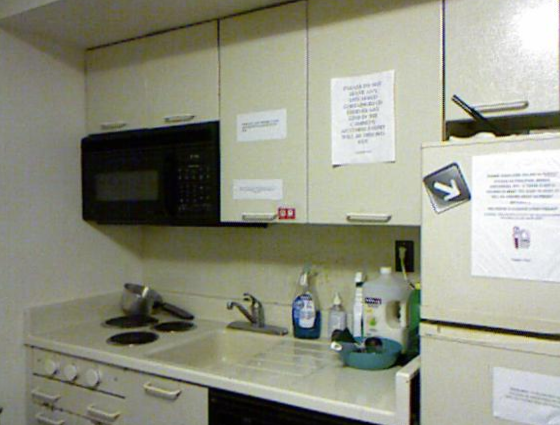

Question:	 how many white objects in this picture
Answer:		 9 (Label: 19)
/kaggle/input/processed-daquar-dataset/images/image2.png
Predicted Answer:	 1
Similarity: 0.875




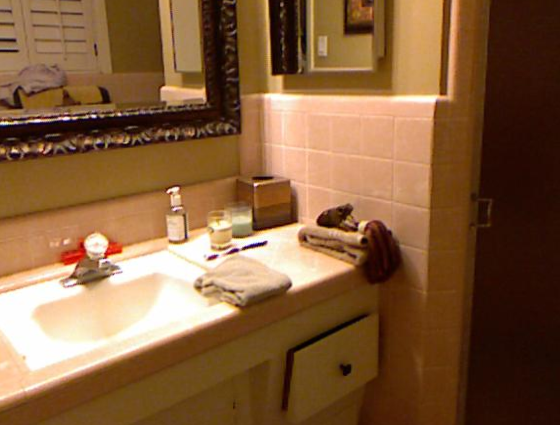

Question:	 how many mirrors are there
Answer:		 2 (Label: 10)
/kaggle/input/processed-daquar-dataset/images/image679.png
Predicted Answer:	 1
Similarity: 0.875




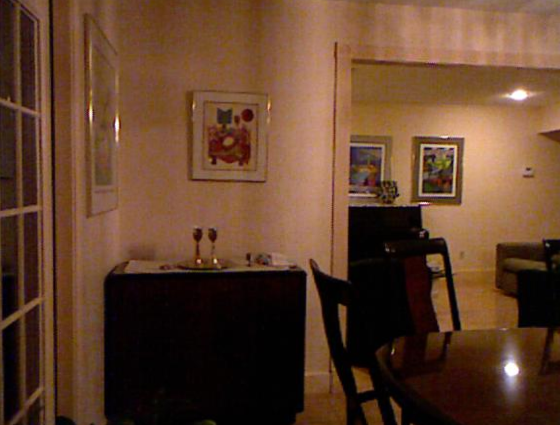

Question:	 what is beneath the candle holder
Answer:		 decorative_plate (Label: 157)
/kaggle/input/processed-daquar-dataset/images/image1365.png
Predicted Answer:	 decorative_plate
Similarity: 0.5




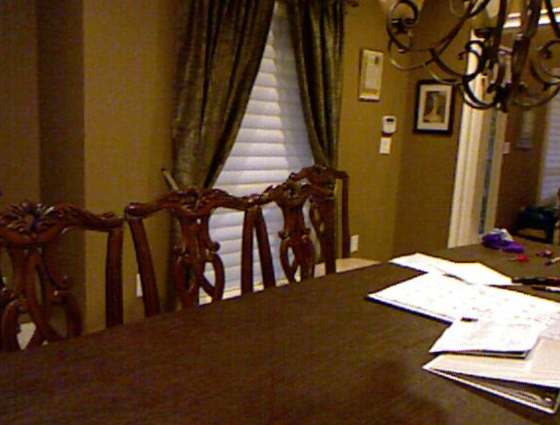

Question:	 what is at the right top
Answer:		 chandelier (Label: 107)
/kaggle/input/processed-daquar-dataset/images/image1399.png
Predicted Answer:	 lamp
Similarity: 0.5882352941176471




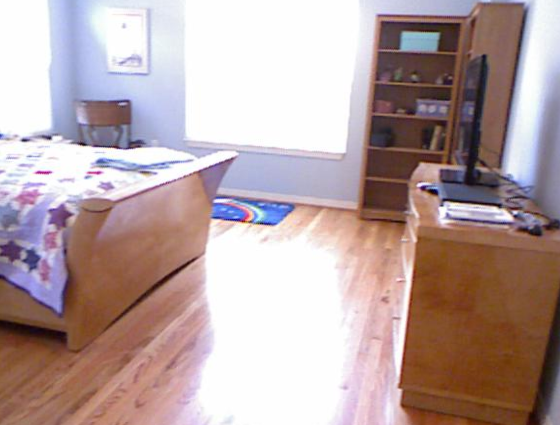

Question:	 what is on the right side of the television
Answer:		 paper, book (Label: 359)
/kaggle/input/processed-daquar-dataset/images/image1150.png
Predicted Answer:	 table
Similarity: 0.21634615384615385




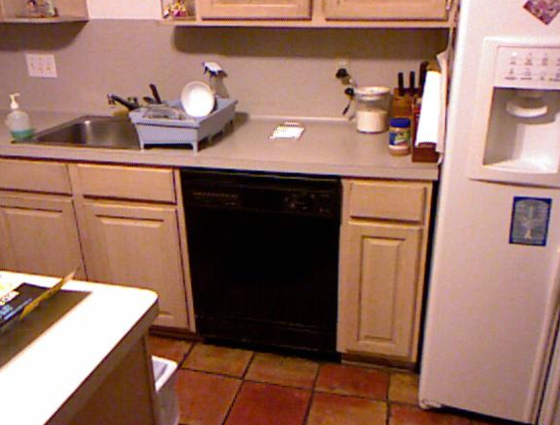

Question:	 what is the object below the counter
Answer:		 dishwasher (Label: 166)
/kaggle/input/processed-daquar-dataset/images/image775.png
Predicted Answer:	 cabinet
Similarity: 0.47619047619047616




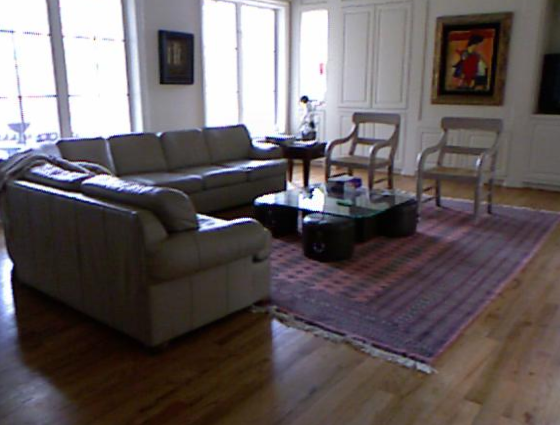

Question:	 what is to the right of the sofa
Answer:		 table (Label: 483)
/kaggle/input/processed-daquar-dataset/images/image1280.png
Predicted Answer:	 table
Similarity: 1.0




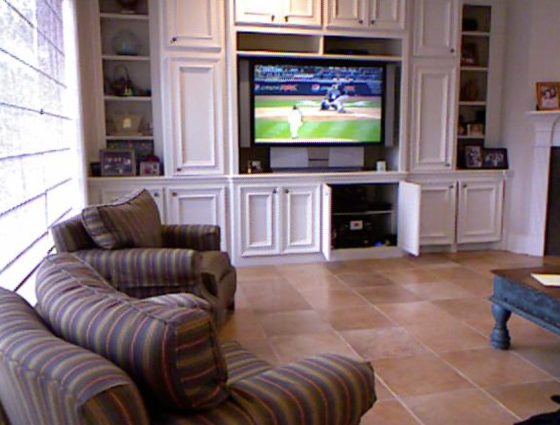

Question:	 what are the things in the cabinet
Answer:		 photo, toy, television, dvd_player (Label: 377)
/kaggle/input/processed-daquar-dataset/images/image1261.png
Predicted Answer:	 photo
Similarity: 0.6591970121381886




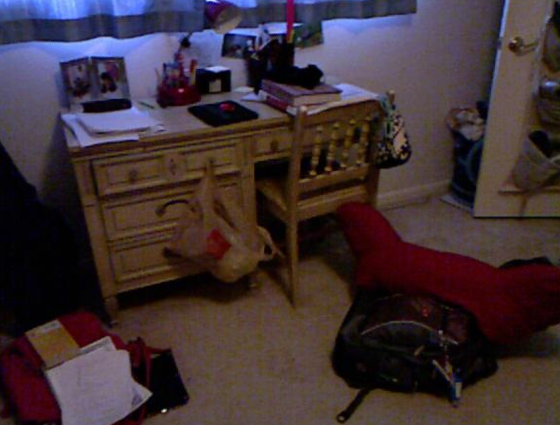

Question:	 how many drawers are there
Answer:		 5 (Label: 15)
/kaggle/input/processed-daquar-dataset/images/image1154.png
Predicted Answer:	 6
Similarity: 0.875




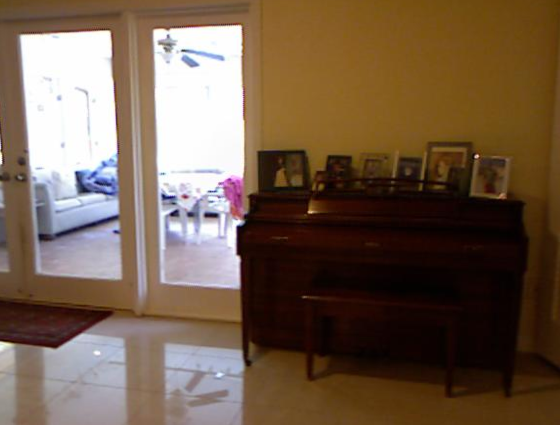

Question:	 what is on the piano
Answer:		 picture (Label: 381)
/kaggle/input/processed-daquar-dataset/images/image1330.png
Predicted Answer:	 decorative_item
Similarity: 0.07692307692307693




In [42]:

j=0
for i in random_sample_indices:
    real_answer = show_example(train=False, idx=i)
    predicted_answer = answer_space[predictions[j]]
    j+=1
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")


In [27]:
def count_trainable_parameters(model):
    """
    Count and print the number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        None
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of trainable parameters: {:,}".format(num_params))
count_trainable_parameters(model)

Number of trainable parameters: 212,123,462


# Testing with Random image

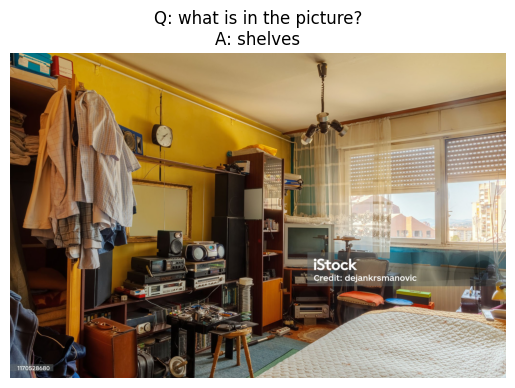

Predicted Answer:	 shelves


In [39]:
import requests
from PIL import Image
from io import BytesIO
import torch
from transformers import RobertaTokenizer
from torchvision import transforms
import matplotlib.pyplot as plt

# Initialize model, tokenizer, and collator (assuming you have these from your notebook)
model = MultimodalVQAModel()  # Replace with actual model initialization
model.load_state_dict(safetensors.torch.load_file('/kaggle/working/model.safetensors'))  # Load the trained model weights
# model.to(device)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  # Replace with actual tokenizer

# Function to download and preprocess the image
def download_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

# Function to preprocess the image
def preprocess_image(image, image_size):
    preprocess = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0).to(device)  # Add batch dimension

# Function to tokenize the question
def tokenize_question(question):
    return tokenizer(question, return_tensors="pt", padding=True, truncation=True)

# Example image and question
image_url = "https://media.istockphoto.com/id/1170528680/photo/old-retro-room.jpg?s=2048x2048&w=is&k=20&c=47REC1Z6prvIXpzNnZ3Wg_A9qCQ97FwhUnovN3nUh8o="
question = "what is in the picture?"

# Download and preprocess the image
image = download_image(image_url)
preprocessed_image = preprocess_image(image, (224, 224))  # Resize to the expected input size of the model

# Tokenize the question
question_tokens = tokenize_question(question)

# Prepare the input for the model
input_data = {
    "input_ids": question_tokens["input_ids"],
    "attention_mask": question_tokens["attention_mask"],
    "pixel_values": preprocessed_image,
}

# Move the input data to the appropriate device
input_ids = input_data["input_ids"].to(device)
attention_mask = input_data["attention_mask"].to(device)
pixel_values = input_data["pixel_values"].to(device)

# Set the model to evaluation mode
model.eval()

# Perform the forward pass
with torch.no_grad():
    output = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)

# Extract and print the predictions
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predicted_answer = answer_space[predictions[0]]

plt.imshow(image)  # Display the original PIL image
plt.title(f"Q: {question}\nA: {predicted_answer}")
plt.axis('off')
plt.show()

print("Predicted Answer:\t", predicted_answer)